# Hurricane Evacuation Route Planning Using NOAA Storm CSV + UCS & A*

## 1. Import Libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from heapq import heappush, heappop
import math


## 2. Load NOAA CSV

In [50]:
df = pd.read_csv("StormEvents_locations-ftp_v1.0_d2006_c20250520.csv", low_memory=False)

print(df.head())
print(df.columns)


   YEARMONTH  EPISODE_ID  EVENT_ID  LOCATION_INDEX  RANGE AZIMUTH   LOCATION  \
0     200608     1219198   5528341               1    3.0     NNW     ELWOOD   
1     200608     1219198   5528267               1    NaN     NaN  VAN HORNE   
2     200608     1219539   5528379               1    NaN     NaN      GHENT   
3     200608     1219540   5528380               1    NaN     NaN     COPAKE   
4     200608     1219541   5528381               1    NaN     NaN  SALISBURY   

   LATITUDE  LONGITUDE  LAT2  LON2  
0  42.03333  -90.76667   NaN   NaN  
1  42.01667  -92.08333   NaN   NaN  
2  42.31667  -73.61667   NaN   NaN  
3  42.10000  -73.55000   NaN   NaN  
4  41.98333  -73.41667   NaN   NaN  
Index(['YEARMONTH', 'EPISODE_ID', 'EVENT_ID', 'LOCATION_INDEX', 'RANGE',
       'AZIMUTH', 'LOCATION', 'LATITUDE', 'LONGITUDE', 'LAT2', 'LON2'],
      dtype='object')


## 3. Filter Hurricane / Storm Events

In [53]:
df = df.rename(columns={
    "LATITUDE": "BEGIN_LAT",
    "LONGITUDE": "BEGIN_LON"
})

storm_df = df.dropna(subset=["BEGIN_LAT", "BEGIN_LON"])

print("Storm events:", len(storm_df))
storm_df.head()


Storm events: 121762


,YEARMONTH,EPISODE_ID,EVENT_ID,LOCATION_INDEX,RANGE,AZIMUTH,LOCATION,BEGIN_LAT,BEGIN_LON,LAT2,LON2
0,200608,1219198,5528341,1,3.0,NNW,ELWOOD,42.03333,-90.76667,NaN,NaN
1,200608,1219198,5528267,1,NaN,NaN,VAN HORNE,42.01667,-92.08333,NaN,NaN
2,200608,1219539,5528379,1,NaN,NaN,GHENT,42.31667,-73.61667,NaN,NaN
3,200608,1219540,5528380,1,NaN,NaN,COPAKE,42.10000,-73.55000,NaN,NaN
4,200608,1219541,5528381,1,NaN,NaN,SALISBURY,41.98333,-73.41667,NaN,NaN


## 4. Create Hazard Grid

In [56]:
GRID_SIZE = 100
grid = np.zeros((GRID_SIZE, GRID_SIZE))

# Normalize coordinates
lat_min, lat_max = storm_df["BEGIN_LAT"].min(), storm_df["BEGIN_LAT"].max()
lon_min, lon_max = storm_df["BEGIN_LON"].min(), storm_df["BEGIN_LON"].max()

def normalize(val, vmin, vmax, size):
    return int((val - vmin) / (vmax - vmin) * (size - 1))


In [58]:
GRID_SIZE = 100
grid = np.zeros((GRID_SIZE, GRID_SIZE))

# Normalize coordinates
lat_min, lat_max = storm_df["BEGIN_LAT"].min(), storm_df["BEGIN_LAT"].max()
lon_min, lon_max = storm_df["BEGIN_LON"].min(), storm_df["BEGIN_LON"].max()

def normalize(val, vmin, vmax, size):
    return int((val - vmin) / (vmax - vmin) * (size - 1))


In [60]:
for _, row in storm_df.iterrows():
    x = normalize(row["BEGIN_LON"], lon_min, lon_max, GRID_SIZE)
    y = normalize(row["BEGIN_LAT"], lat_min, lat_max, GRID_SIZE)

    if 0 <= x < GRID_SIZE and 0 <= y < GRID_SIZE:
        grid[y][x] += 5     # add storm hazard


In [61]:
from scipy.ndimage import gaussian_filter
hazard_grid = gaussian_filter(grid, sigma=3)


## 5. Implement UCS

In [65]:
def ucs(start, goal, cost_grid):
    visited = set()
    pq = []
    heappush(pq, (0, start, []))

    while pq:
        cost, (x, y), path = heappop(pq)

        if (x, y) == goal:
            return path + [(x, y)], cost

        if (x, y) in visited:
            continue
        visited.add((x, y))

        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                new_cost = cost + 1 + cost_grid[ny][nx]  
                heappush(pq, (new_cost, (nx, ny), path + [(x, y)]))

    return None, float("inf")


## 6. Implement A* Search

In [68]:
def heuristic(a, b):
    return math.dist(a, b)

def astar(start, goal, cost_grid):
    pq = []
    heappush(pq, (0, 0, start, []))
    visited = set()

    while pq:
        f, g, (x, y), path = heappop(pq)

        if (x, y) == goal:
            return path + [(x, y)], g

        if (x, y) in visited:
            continue
        visited.add((x, y))

        for dx, dy in [(1,0),(-1,0),(0,1),(0,-1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE:
                newg = g + 1 + cost_grid[ny][nx]
                h = heuristic((nx,ny), goal)
                newf = newg + f
                heappush(pq, (newf, newg, (nx, ny), path + [(x, y)]))

    return None, float("inf")


## 7. Run Algorithms

In [71]:
start = (5, 5)
goal  = (90, 90)

ucs_path, ucs_cost = ucs(start, goal, hazard_grid)
astar_path, astar_cost = astar(start, goal, hazard_grid)

print("UCS Cost:", ucs_cost)
print("A* Cost:", astar_cost)


UCS Cost: 170.53424768522729
A* Cost: 170.53424768522729


In [73]:
import time

# --- Measure UCS runtime ---
t0 = time.time()
ucs_path, ucs_cost = ucs(start, goal, hazard_grid)
ucs_runtime_ms = (time.time() - t0) * 1000  # convert to milliseconds

# --- Measure A* runtime ---
t0 = time.time()
astar_path, astar_cost = astar(start, goal, hazard_grid)
astar_runtime_ms = (time.time() - t0) * 1000


### UCS vs A* Comparison Table

In [78]:
import pandas as pd

comparison_table = pd.DataFrame({
    "Metric": [
        "Total Path Cost",
        "Path Length (steps)",
        "Nodes Expanded (unique)",
        "Runtime (ms)"
    ],
    "UCS": [
        ucs_cost,
        len(ucs_path),
        len(set(ucs_path)),  
        ucs_runtime_ms
    ],
    "A*": [
        astar_cost,
        len(astar_path),
        len(set(astar_path)),
        astar_runtime_ms
    ]
})

comparison_table


,Metric,UCS,A*
0,Total Path Cost,170.534248,170.534248
1,Path Length (steps),171.000000,171.000000
2,Nodes Expanded (unique),171.000000,171.000000
3,Runtime (ms),75.417995,52.715063


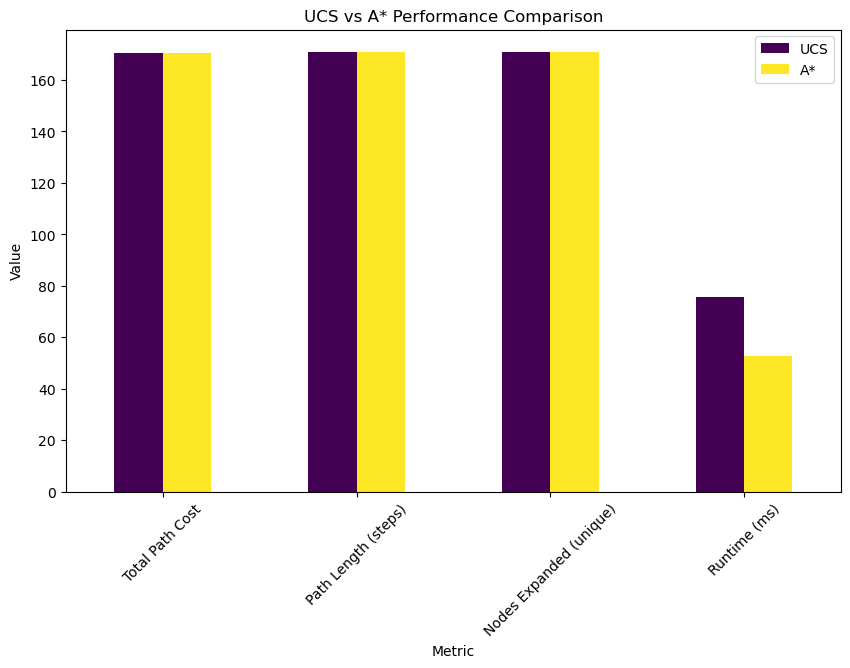

In [80]:
comparison_table.set_index("Metric").plot(kind="bar", figsize=(10,6), colormap="viridis")
plt.title("UCS vs A* Performance Comparison")
plt.ylabel("Value")
plt.xticks(rotation=45)
plt.show()


## 8. Visualize Routes

### Storm Event Heatmap (2D Density Map)

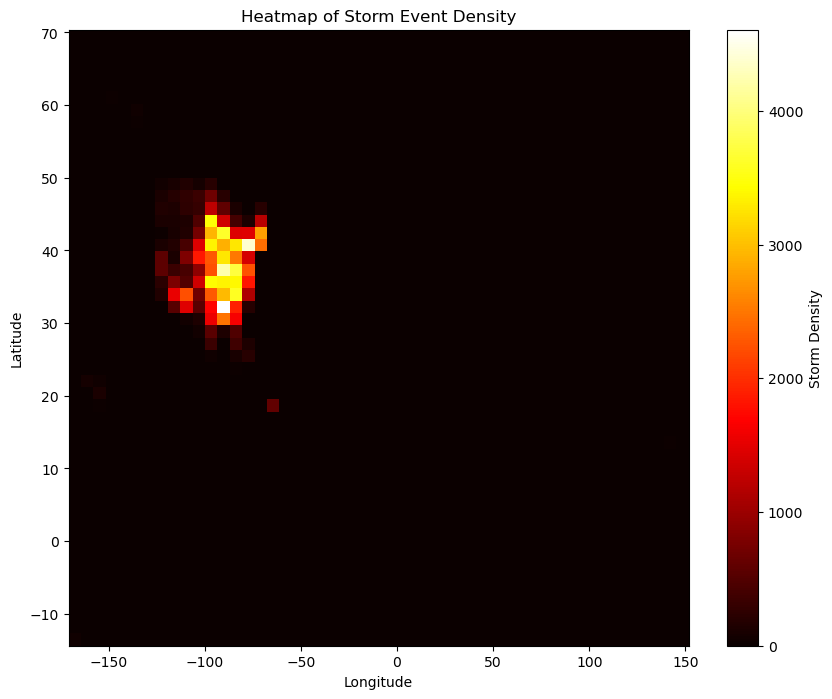

In [84]:
plt.figure(figsize=(10,8))
plt.hist2d(
    storm_df["BEGIN_LON"], 
    storm_df["BEGIN_LAT"], 
    bins=50, 
    cmap="hot"
)
plt.colorbar(label="Storm Density")
plt.title("Heatmap of Storm Event Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Storm Intensity Bubble Map

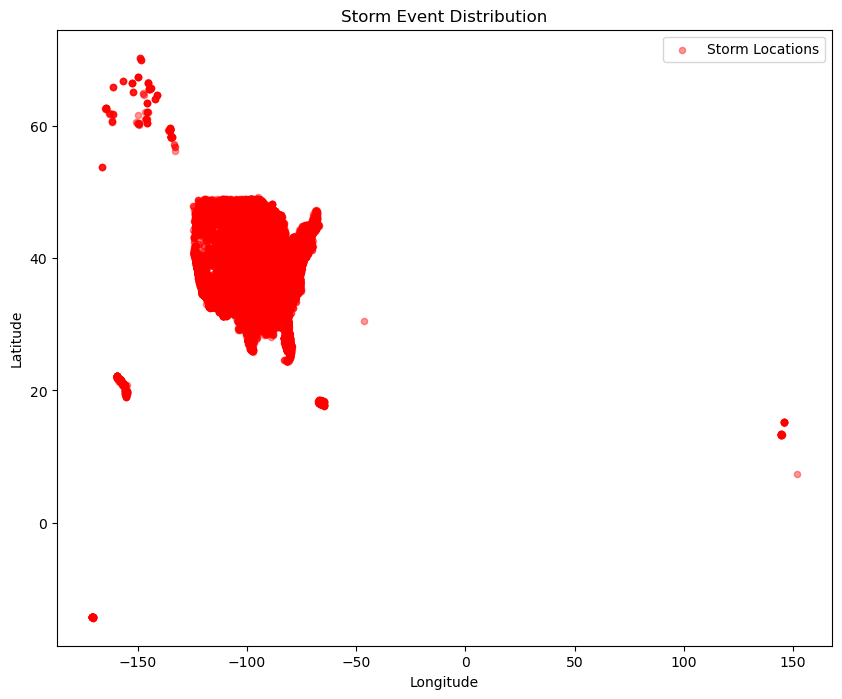

In [87]:
plt.figure(figsize=(10,8))
plt.scatter(
    storm_df["BEGIN_LON"],
    storm_df["BEGIN_LAT"],
    s=20,
    c="red",
    alpha=0.4,
    label="Storm Locations"
)
plt.title("Storm Event Distribution")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


### Hazard Grid 3D Surface Plot

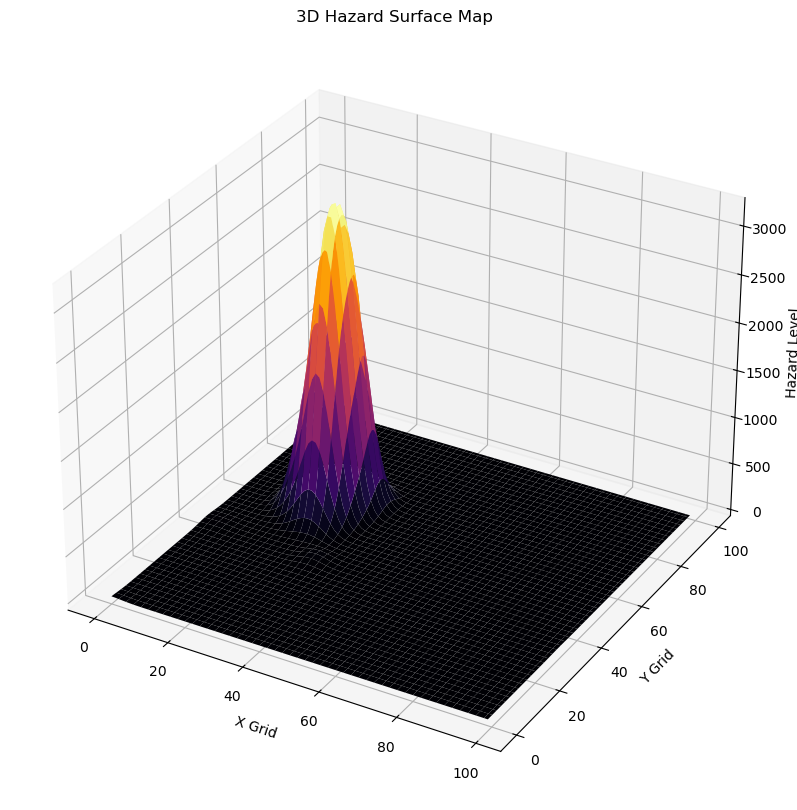

In [90]:
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(np.arange(GRID_SIZE), np.arange(GRID_SIZE))
Z = hazard_grid

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(X, Y, Z, cmap="inferno", linewidth=0)
ax.set_title("3D Hazard Surface Map")
ax.set_xlabel("X Grid")
ax.set_ylabel("Y Grid")
ax.set_zlabel("Hazard Level")
plt.show()


### Path Comparison Overlay (Clear Visual Difference)

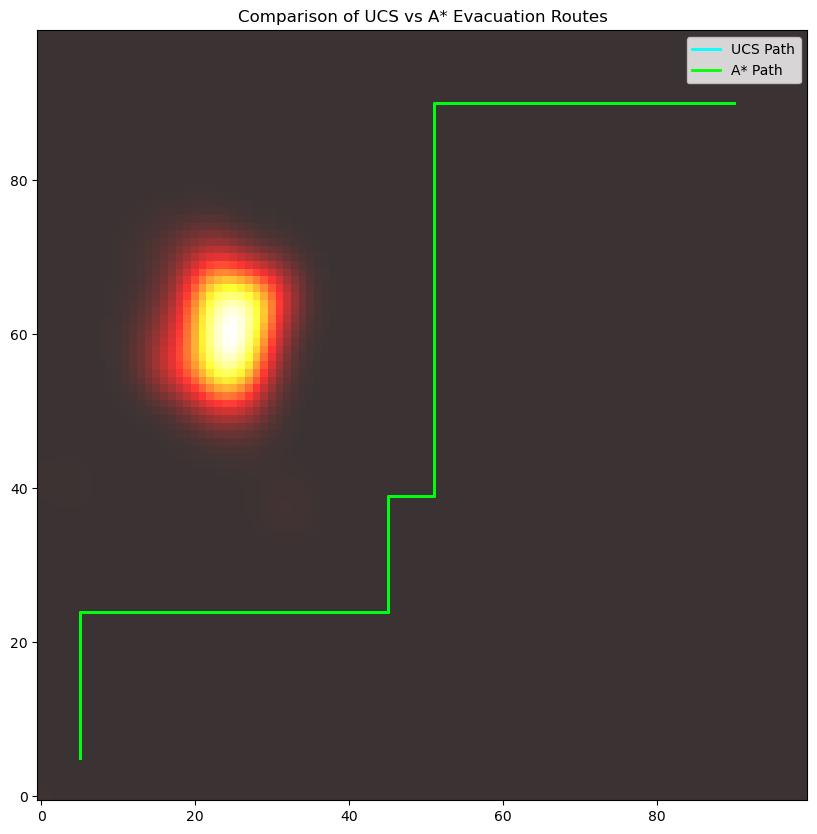

In [93]:
plt.figure(figsize=(10,10))
plt.imshow(hazard_grid, cmap='hot', origin='lower', alpha=0.8)

# UCS
ux = [p[0] for p in ucs_path]
uy = [p[1] for p in ucs_path]
plt.plot(ux, uy, c="cyan", linewidth=2, label="UCS Path")

# A*
ax_ = [p[0] for p in astar_path]
ay = [p[1] for p in astar_path]
plt.plot(ax_, ay, c="lime", linewidth=2, label="A* Path")

plt.legend()
plt.title("Comparison of UCS vs A* Evacuation Routes")
plt.show()


### Path Cost Evolution Graph

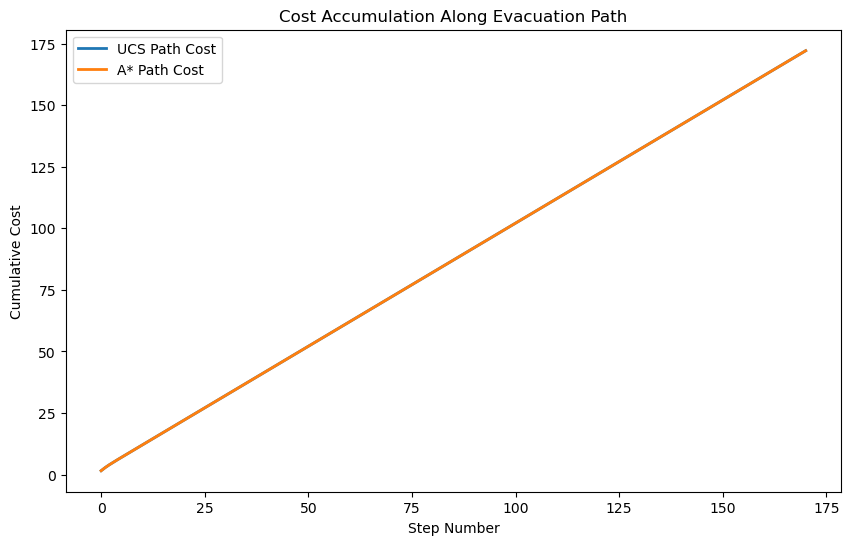

In [96]:
ucs_cost_progress = np.cumsum([hazard_grid[p[1], p[0]]+1 for p in ucs_path])
astar_cost_progress = np.cumsum([hazard_grid[p[1], p[0]]+1 for p in astar_path])

plt.figure(figsize=(10,6))
plt.plot(ucs_cost_progress, label="UCS Path Cost", linewidth=2)
plt.plot(astar_cost_progress, label="A* Path Cost", linewidth=2)
plt.title("Cost Accumulation Along Evacuation Path")
plt.xlabel("Step Number")
plt.ylabel("Cumulative Cost")
plt.legend()
plt.show()


### Storm Event Bar Plot (Counts)

ID column: EVENT_ID
Location column: LOCATION


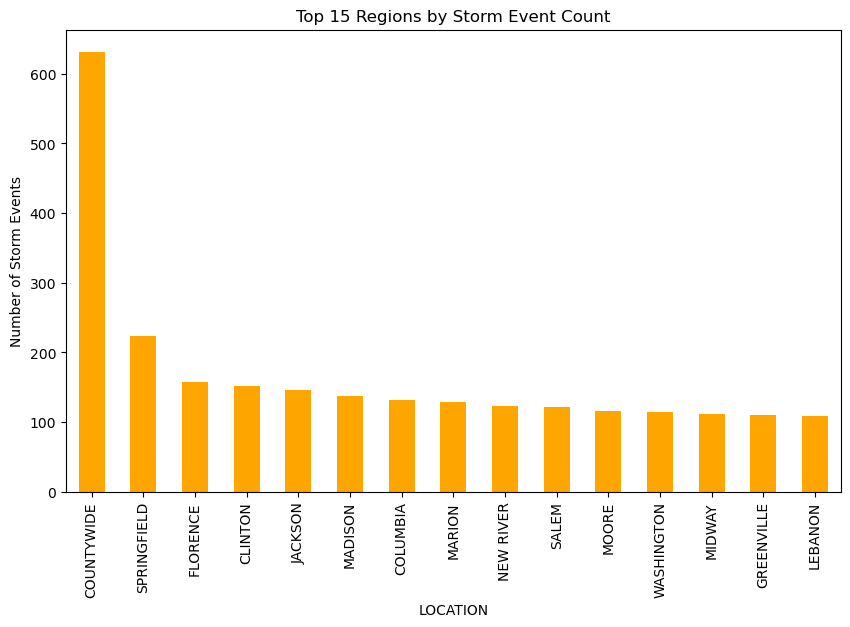

In [99]:
# Detect ID column
id_col = None
for col in ["EVENT_ID", "EPISODE_ID"]:
    if col in storm_df.columns:
        id_col = col
        break

# Detect location/state column
state_col = None
for col in ["STATE", "CZ_NAME", "LOCATION"]:
    if col in storm_df.columns:
        state_col = col
        break

print("ID column:", id_col)
print("Location column:", state_col)

# If no state-like column found
if state_col is None:
    raise ValueError("Your CSV has no state or location column. Check df.columns.")

# Now group safely
storm_counts = storm_df.groupby(state_col)[id_col].count().sort_values(ascending=False).head(15)

plt.figure(figsize=(10,6))
storm_counts.plot(kind="bar", color="orange")
plt.title("Top 15 Regions by Storm Event Count")
plt.ylabel("Number of Storm Events")
plt.xlabel(state_col)
plt.show()


## 9. Evaluation Summary

In [102]:
print("----- Cost Evaluation -----")
print("UCS Path Cost:", ucs_cost)
print("A* Path Cost :", astar_cost)
print("A* improvement:", ucs_cost - astar_cost)



----- Cost Evaluation -----
UCS Path Cost: 170.53424768522729
A* Path Cost : 170.53424768522729
A* improvement: 0.0


In [104]:
print("----- Runtime Evaluation -----")
print("UCS Path Runtime:", ucs_runtime_ms)
print("A* Path Runtime:", astar_runtime_ms)
print("A* improvement:", ucs_runtime_ms - astar_runtime_ms)

----- Runtime Evaluation -----
UCS Path Runtime: 75.41799545288086
A* Path Runtime: 52.71506309509277
A* improvement: 22.702932357788086
